# Crop simulation

Doing imports 

In [1]:
%matplotlib inline
#%matplotlib notebook
import sys
import pcse
import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

This notebook was built with:
python version: 3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]
PCSE version: 6.0.9


## Weather & Solar data 

### 1. Transform the data into the right units


| Identifier | Parameter   | Description                              | From Unit  | To Unit           | Dataset |
|------------|-------------|------------------------------------------|------------|-------------------|---------|
| TXK        | TMAX        | Daily maximum temperature                | °C         | °C                | KL      |
| TNK        | TMIN        | Daily minimum temperature                | °C         | °C                | KL      |
| VPM        | VAP         | Mean daily vapour pressure               | hPa        | kPa               | KL      |
| FM         | WIND        | Mean daily wind speed at 2 m above ground level | m/s        | m/s       | KL      |
| RSK        | RAIN        | Precipitation                            | mm         | mm   | KL      |
| FG_STRAHL  | IRRAD       | Daily global radiation                   | J/cm^2     | kJ/m^{-2} | Solar   |
| SHK_TAG    | SNOWDEPTH   | Depth of snow cover (optional)           | cm         | cm                | KL      |

##### Climate and Solar data

In [ ]:
# Read the text file into a DataFrame
data_bremen_kl = pd.read_csv('data_kl/bremen_daily_kl/tageswerte_KL_00691_18900101_20231231_hist/produkt_klima_tag_18900101_20231231_00691.txt', delimiter=';', skipfooter=1, engine='python')
data_chemnitz_kl = pd.read_csv('data_kl/chemnitz_daily_kl/tageswerte_KL_00853_18820101_20231231_hist/produkt_klima_tag_18820101_20231231_00853.txt', delimiter=';', skipfooter=1, engine='python')

data_bremen_solar = pd.read_csv('data_solar/bremen/tageswerte_ST_00691_row/produkt_st_tag_20090101_20250331_00691.txt', delimiter=';', skipfooter=1, engine='python')
data_chemnitz_solar = pd.read_csv('data_solar/chemnitz/tageswerte_ST_00853_row/produkt_st_tag_19810101_20250331_00853.txt', delimiter=';', skipfooter=1, engine='python')

# Convert units -> mm to cm, ensuring column names are stripped of extra spaces
data_bremen_kl.columns = data_bremen_kl.columns.str.strip()
data_chemnitz_kl.columns = data_chemnitz_kl.columns.str.strip()

# Replace -999 with NaN
data_bremen_kl.replace(-999, np.nan, inplace=True)
data_chemnitz_kl.replace(-999, np.nan, inplace=True)

data_bremen_solar.replace(-999, np.nan, inplace=True)
data_chemnitz_solar.replace(-999, np.nan, inplace=True)


##### Find the rows without NaNs


In [47]:
# Create a boolean mask for rows without NaN values
mask_bremen = data_bremen_solar.notna().all(axis=1)
mask_chemnitz = data_chemnitz_solar.notna().all(axis=1)

# Filter and print the rows without NaN values
data_bremen_solar_cleaned = data_bremen_solar[mask_bremen]
data_chemnitz_solar_cleaned = data_chemnitz_solar[mask_chemnitz]

print("Bremen Solar Data without NaNs:")
print(data_bremen_solar_cleaned)

print("Chemnitz Solar Data without NaNs:")
print(data_chemnitz_solar_cleaned)

Bremen Solar Data without NaNs:
Empty DataFrame
Columns: [STATIONS_ID, MESS_DATUM, QN_592, ATMO_STRAHL, FD_STRAHL, FG_STRAHL, SD_STRAHL, eor]
Index: []
Chemnitz Solar Data without NaNs:
Empty DataFrame
Columns: [STATIONS_ID, MESS_DATUM, QN_592, ATMO_STRAHL, FD_STRAHL, FG_STRAHL, SD_STRAHL, eor]
Index: []


### 2. Transform to PCSE data format

In [48]:
# Map and transform the data to PCSE format
data_bremen_pcse = pd.DataFrame({
    #'DAY': pd.to_datetime(data_bremen_kl['MESS_DATUM'], format='%Y%m%d'),
    'DAY': data_bremen_kl['MESS_DATUM'],
    'IRRAD': data_bremen_solar['FG_STRAHL'] * 10,  # Convert J/cm² to kJ/m²
    'TMIN': data_bremen_kl['TNK'],  # Example: map to minimum temperature
    'TMAX': data_bremen_kl['TXK'],  # Example: map to maximum temperature
    'VAP': data_bremen_kl['VPM'],  # Example: map to vapor pressure
    'WIND': data_bremen_kl['FM'],  # Assuming this is the wind speed
    'RAIN': data_bremen_kl['RSK'] / 10,  # Convert mm to cm
    'SNOW': np.nan # -999  # Fill snow depth with NaN
})
#print(data_bremen_pcse)

#data_bremen_pcse.replace(np.nan, int(-999), inplace=True)
#data_bremen_pcse['IRRAD'] = data_chemnitz_pcse['IRRAD'].astype(int)

In [49]:
# Map and transform the data to PCSE format
data_chemnitz_pcse = pd.DataFrame({
    #'DAY': pd.to_datetime(data_chemnitz_kl['MESS_DATUM'], format='%Y%m%d'),
    'DAY': data_chemnitz_kl['MESS_DATUM'],
    'IRRAD': data_chemnitz_solar['FG_STRAHL'] * 10000,  # Convert J/cm² to J/m²
    'TMIN': data_chemnitz_kl['TNK'],  # Example: map to minimum temperature
    'TMAX': data_chemnitz_kl['TXK'],  # Example: map to maximum temperature
    'VAP': data_chemnitz_kl['VPM'],  # Example: map to vapor pressure
    'WIND': data_chemnitz_kl['FM'],  # Assuming this is the wind speed
    'RAIN': data_chemnitz_kl['RSK'] / 10,  # Convert mm to cm if needed
    'SNOW': np.nan  # Fill snow depth with NaN
})

#print(data_chemnitz_pcse)

#data_chemnitz_pcse.replace(np.nan, int(-999), inplace=True)
#data_chemnitz_pcse['your_column_name'].replace(np.nan, -999, inplace=True)
#data_chemnitz_pcse['IRRAD'] = data_chemnitz_pcse['IRRAD'].astype(int)


##### Write to CSV file without site characteristics / meta data

In [50]:
# Write to CSV file without site characteristics / meta data
data_chemnitz_pcse.to_csv('CSV_chemnitz_pcse_ohneMeta.csv', index=False, na_rep='NaN')
data_bremen_pcse.to_csv('CSV_bremen_pcse_ohneMeta.csv', index=False, na_rep='NaN')

### 3. Insert site characteristics into the CSV

In [51]:
# Site characteristics as a string
site_characteristics = """## Site Characteristics
Country     = 'Germany'
Station     = 'Chemnitz'
Description = 'Observed data from Station Chemnitz'
Source      = 'Your Data Source'
Contact     = 'Your Contact'
Longitude = 12.92; Latitude = 50.83; Elevation = 300; AngstromA = 0.25; AngstromB = 0.50; HasSunshine = False
## Daily weather observations (missing values are NaN)
"""

# Filter the data for a specific date range (e.g., from 2009-01-01 to 2023-12-31)
csv_data = data_chemnitz_pcse[data_chemnitz_pcse['DAY'] >= 20090101]

# Convert DataFrame to CSV string
csv_data = csv_data.to_csv(index=False, na_rep='NaN')

# Combine site characteristics and CSV data
full_csv_content = site_characteristics + csv_data

# Write to CSV file
with open('chemnitz_withMeta.csv', 'w', newline='') as f:
    f.write(full_csv_content)
    #f.write(csv_data)

print("CSV file with site characteristics created.")

CSV file with site characteristics created.


In [52]:
# Read the CSV file and inspect the column names
day_test = pd.read_csv('chemnitz_withMeta.csv', delimiter=',', skiprows=8, nrows=1)
print("Column names in the CSV:", day_test.columns)

# Ensure the 'DAY' column exists and access it correctly
if 'DAY' in day_test.columns:
	print(day_test['DAY'])
else:
	print("The 'DAY' column does not exist in the CSV file.")

Column names in the CSV: Index(['DAY', 'IRRAD', 'TMIN', 'TMAX', 'VAP', 'WIND', 'RAIN', 'SNOW'], dtype='object')
0    20090101
Name: DAY, dtype: int64


In [53]:
# Define the CSV content
csv_content = """## Site Characteristics
Country='Germany'; Station='Chemnitz'; Description='Observed data'; Source='Your Source'; Contact='Your Contact'; Longitude=12.92; Latitude=50.83; Elevation=300; AngstromA=0.25; AngstromB=0.50; HasSunshine=False
## Daily weather observations (missing values are NaN)
DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOW
20090101,100,0,-5,1,2,0,0
20090102,150,1,-4,2,3,0,0
"""

# Write to the CSV file
with open('chemnitz_minimal_example.csv', 'w', newline='') as f:
    f.write(csv_content)

print("CSV file 'chemnitz_minimal_example.csv' created successfully.")

CSV file 'chemnitz_minimal_example.csv' created successfully.


In [54]:
from pcse.input import CSVWeatherDataProvider
import csv

# Load the weather data provider
# Ensure the weather file is correctly formatted for PCSE
#weatherfile = "chemnitz_withMeta.csv"
weatherfile = "chemnitz_minimal_example.csv"

# Open the CSV file and read its contents
with open(weatherfile, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        print(row)  # Print each row as a list

weatherdataprovider = CSVWeatherDataProvider(weatherfile)

# Debugging: Inspect the first and last date
print(f"First date: {weatherdataprovider.first_date}")
print(f"Last date: {weatherdataprovider.last_date}")

print(weatherdataprovider)

['## Site Characteristics']
["Country='Germany'; Station='Chemnitz'; Description='Observed data'; Source='Your Source'; Contact='Your Contact'; Longitude=12.92; Latitude=50.83; Elevation=300; AngstromA=0.25; AngstromB=0.50; HasSunshine=False"]
['## Daily weather observations (missing values are NaN)']
['DAY', 'IRRAD', 'TMIN', 'TMAX', 'VAP', 'WIND', 'RAIN', 'SNOW']
['20090101', '100', '0', '-5', '1', '2', '0', '0']
['20090102', '150', '1', '-4', '2', '3', '0', '0']
First date: None
Last date: None


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [ ]:
import pandas as pd

# Read the CSV file, skipping the metadata lines
df = pd.read_csv("chemnitz_withMeta.csv", skiprows=8)  # Skip the first 9 lines containing metadata
print(df.head())

# Check if the 'DAY' column is correctly interpreted as dates
df['DAY'] = pd.to_datetime(df['DAY'], format='%Y%m%d')
print(df['DAY'].head())

        DAY  IRRAD  TMIN  TMAX  VAP  WIND  RAIN  SNOW
0  20090101    NaN  -7.5  -4.5  3.7   3.7  0.01   NaN
1  20090102    NaN  -5.6  -3.1  4.4   2.3  0.06   NaN
2  20090103    NaN -10.3  -2.9  3.1   4.0  0.14   NaN
3  20090104    NaN  -3.7  -2.4  4.9   8.3  1.04   NaN
4  20090105    NaN -15.4  -2.2  3.9   5.9  0.08   NaN
0   2009-01-01
1   2009-01-02
2   2009-01-03
3   2009-01-04
4   2009-01-05
Name: DAY, dtype: datetime64[ns]


### Trying with excel

In [ ]:
import pandas as pd
import numpy as np

# Create a DataFrame for the metadata in a structured format
meta_bremen = pd.DataFrame({
    'Country': ["Germany"],
    'Station': ["Chemnitz"],
    'Description': ["Observed data from Station Chemnitz"],
    'Source': ["Your Data Source"],
    'Contact': ["Your Contact"],
    'Longitude': ["12.92"],  # Float
    'Latitude': ["50.83"],    # Float
    'Elevation': ["300"],      # Float
    'AngstromA': ["0.25"],     # Float
    'AngstromB': ["0.50"],     # Float
    'HasSunshine': [False]   # Boolean
})

# Map and transform the data to PCSE format
data_bremen_pcse = pd.DataFrame({
    'DAY': data_bremen_kl['MESS_DATUM'],
    'IRRAD': data_bremen_solar['FG_STRAHL'] * 10000,  # Convert J/cm² to J/m²
    'TMIN': data_bremen_kl['TNK'],  # Minimum temperature
    'TMAX': data_bremen_kl['TXK'],  # Maximum temperature
    'VAP': data_bremen_kl['VPM'],  # Vapor pressure
    'WIND': data_bremen_kl['FM'],  # Wind speed
    'RAIN': data_bremen_kl['RSK'] / 10,  # Convert mm to cm
    'SNOW': np.nan  # Fill snow depth with NaN
})

# Path to save the Excel file
excel_file_path = 'TEST_BREMEN.xlsx'

# Create an Excel writer object
with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
    # Write the metadata to the first sheet
    meta_bremen.to_excel(writer, sheet_name='Data', index=False, header=True, startrow=0)  # Write metadata with header

    # Write the data starting from row 12 (index 11)
    data_bremen_pcse.to_excel(writer, sheet_name='Data', index=False, header=True, startrow=11)  # Write data with header

print(f"Excel file '{excel_file_path}' created successfully with metadata and data.")

Excel file 'TEST_BREMEN.xlsx' created successfully with metadata and data.


## With manually created CSV

In [30]:
from pcse.input import CSVWeatherDataProvider
weatherdataproviderChem2009 = CSVWeatherDataProvider("data_PCSE_prepd/DATA_Chemnitz_2009_prepd_PCSE.csv")
weatherdataproviderChem2020 = CSVWeatherDataProvider("data_PCSE_prepd/DATA_Chemnitz_2020_prepd_PCSE.csv")
weatherdataproviderBre2009 = CSVWeatherDataProvider("data_PCSE_prepd/DATA_Bremen_2009_prepd_PCSE.csv")
weatherdataproviderBre2020 = CSVWeatherDataProvider("data_PCSE_prepd/DATA_Bremen_2020_prepd_PCSE.csv")

#create List
weatherlist = [[weatherdataproviderBre2009,weatherdataproviderBre2020],
               [weatherdataproviderChem2009,weatherdataproviderChem2020]]

## Crop, Soil and Agro Data

In [9]:
from pcse.input import YAMLCropDataProvider
from pcse.models import Wofost72_PP
from pcse.util import DummySoilDataProvider
from pcse.input import WOFOST72SiteDataProvider
from pcse.base import ParameterProvider
from pcse.input import YAMLAgroManagementReader

"""load crop file https://github.com/ajwdewit/WOFOST_crop_parameters"""
cropd = YAMLCropDataProvider(Wofost72_PP) #https://github.com/ajwdewit/WOFOST_crop_parameters
#cropd.print_crops_varieties() #every kind of plant in this library

#activate a specific crop (crop and variety), loaded directly from the PCSE GitHub
cropd.set_active_crop("potato", "Potato_701") #Potato
#cropd.set_active_crop("millet", "Millet_VanHeemst_1988") #Millet (Hirse)
#cropd.set_active_crop("wheat", "Winter_wheat_101") #Wheat
print(cropd)

"""load dummy soil file https://pcse.readthedocs.io/en/stable/code.html#pcse.util.DummySoilDataProvider"""
soild = DummySoilDataProvider()

"""load some standard site; https://pcse.readthedocs.io/en/stable/code.html#wofost72sitedataprovider"""
sited = WOFOST72SiteDataProvider(WAV=10) #WAV = initial soil moisture

"""put everything together with ParameterProvider"""
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

"""agro file"""
agro2009 = YAMLAgroManagementReader("agro/agro_potato_2009.yaml")
agro2020 = YAMLAgroManagementReader("agro/agro_potato_2020.yaml")
agrolist = [agro2009,agro2020]

Crop parameters loaded from: https://raw.githubusercontent.com/ajwdewit/WOFOST_crop_parameters/wofost72
YAMLCropDataProvider - current active crop 'potato' with variety 'Potato_701'
Available crop parameters:
 {'CO2EFFTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.11, 1000.0, 1.11, 2000.0, 1.11], 'CO2TRATB': [40.0, 0.0, 360.0, 1.0, 720.0, 0.9, 1000.0, 0.9, 2000.0, 0.9], 'CO2AMAXTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.6, 1000.0, 1.9, 2000.0, 1.9], 'TBASEM': 3.0, 'TEFFMX': 18.0, 'TSUMEM': 170, 'IDSL': 0, 'DLO': -99.0, 'DLC': -99.0, 'TSUM1': 150, 'TSUM2': 1550, 'DTSMTB': [0.0, 0.0, 2.0, 0.0, 13.0, 11.0, 30.0, 28.0], 'DVSI': 0.0, 'DVSEND': 2.0, 'VERNBASE': 14.0, 'VERNSAT': 70.0, 'VERNDVS': 0.3, 'VERNRTB': [-8.0, 0.0, -4.0, 0.0, 3.0, 1.0, 10.0, 1.0, 17.0, 0.0, 20.0, 0.0], 'TDWI': 75.0, 'RGRLAI': 0.012, 'SLATB': [0.0, 0.003, 1.1, 0.003, 2.0, 0.0015], 'SPA': 0.0, 'SSATB': [0.0, 0.0, 2.0, 0.0], 'SPAN': 37.0, 'TBASE': 2.0, 'KDIFTB': [0.0, 1.0, 2.0, 1.0], 'EFFTB': [0.0, 0.45, 40.0, 0.45], 'AMAXTB': [0.0, 3

### Running the model with the given files

In [33]:
from pcse.models import Wofost72_WLP_CWB

wofsim_results = [[0,0],[0,0]]
#for a in range(len(weatherlist)):
#    for b in range(len(weatherlist[a])):

for a in range(len(weatherlist)):
    for b in range(len(weatherlist[a])):
        wofsim = Wofost72_WLP_CWB(parameters, weatherlist[a][b], agrolist[b])
        wofsim.run(days=271+b) #2020 has one day more
        
        wofsim_results[a][b] = pd.DataFrame(wofsim.get_output())
        wofsim_results[a][b] = wofsim_results[a][b].set_index("day")

Visualization

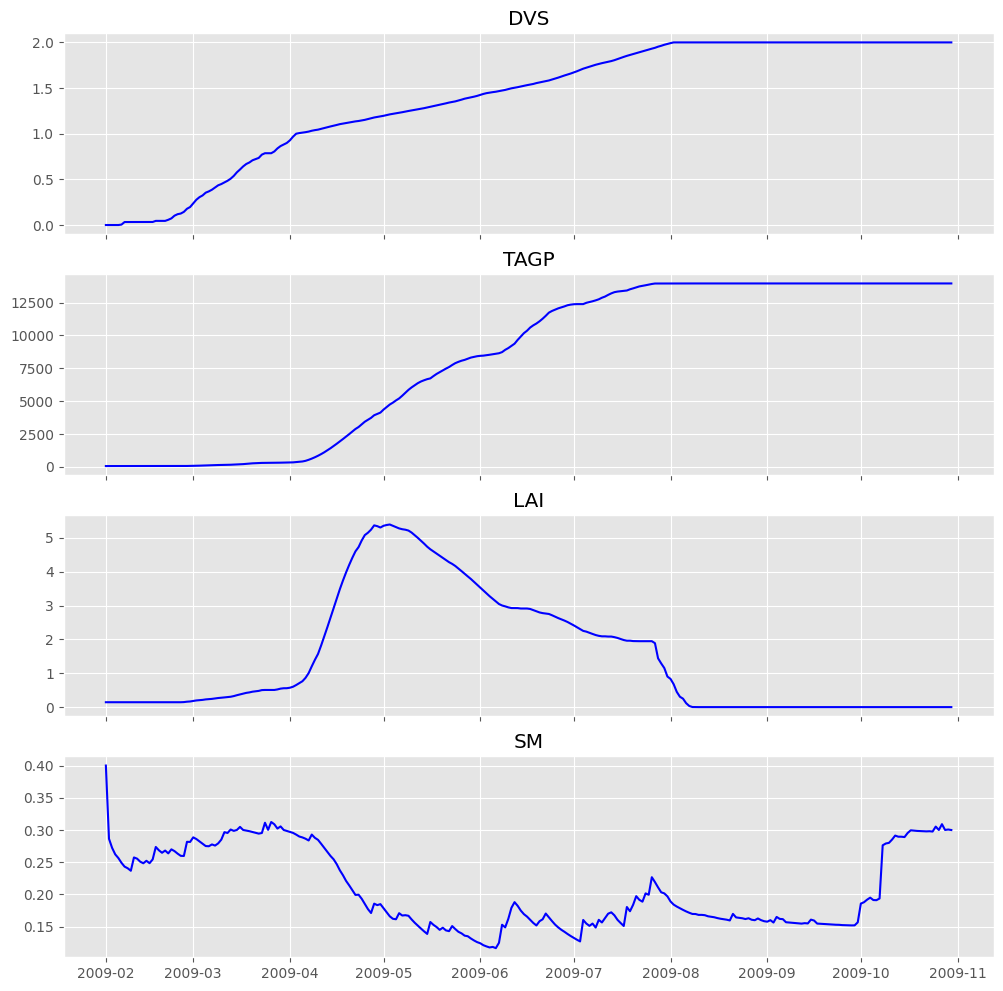

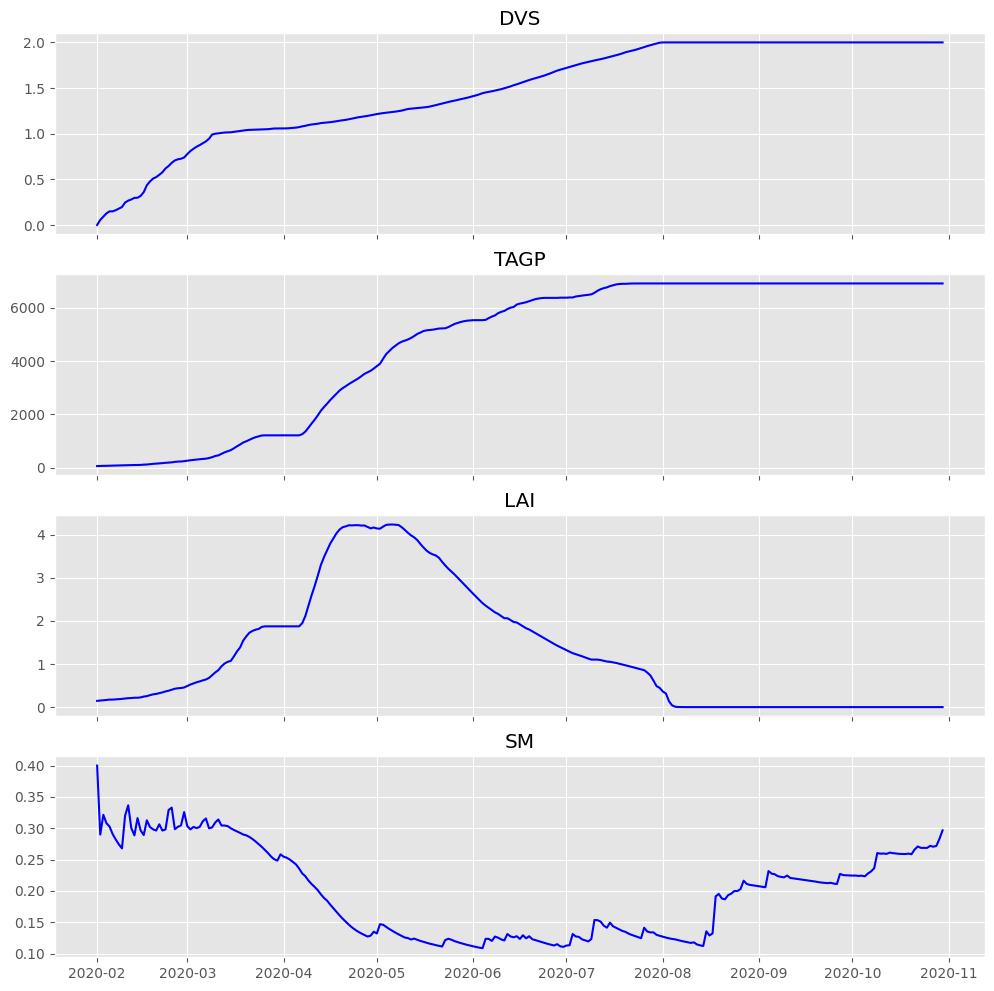

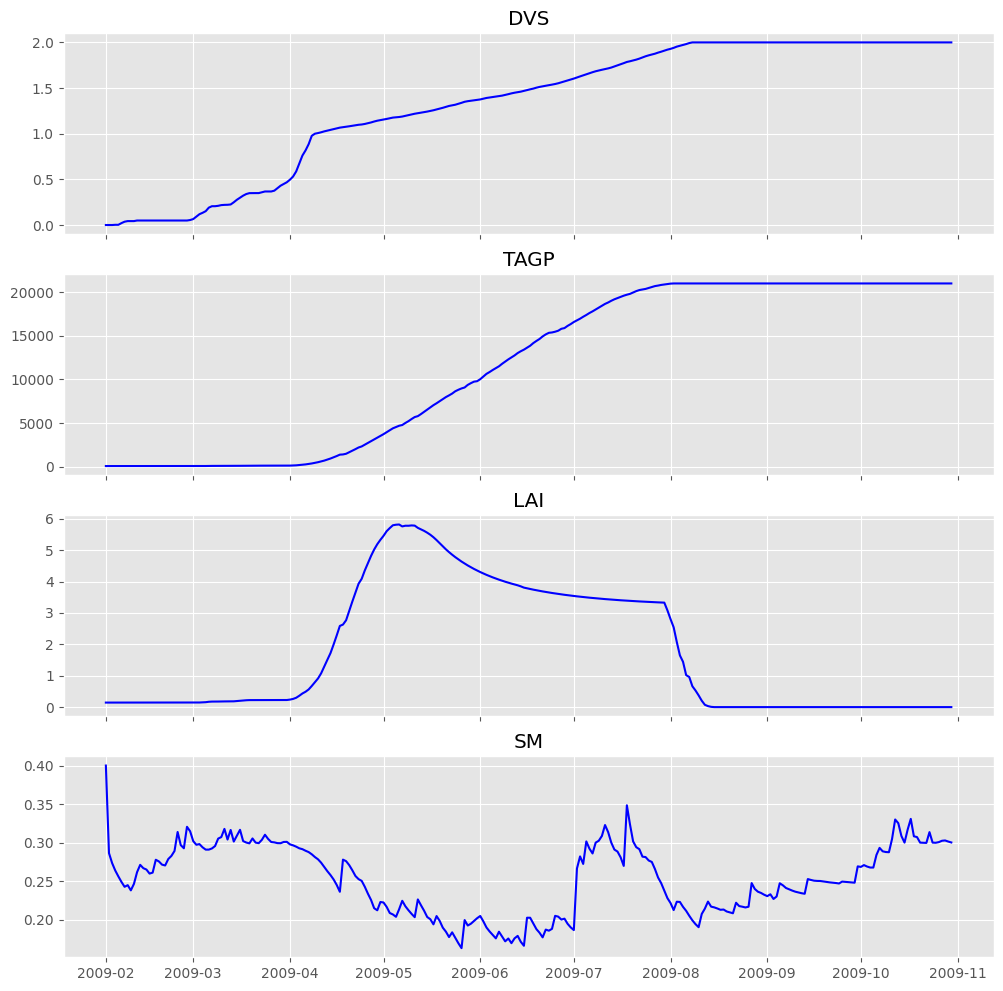

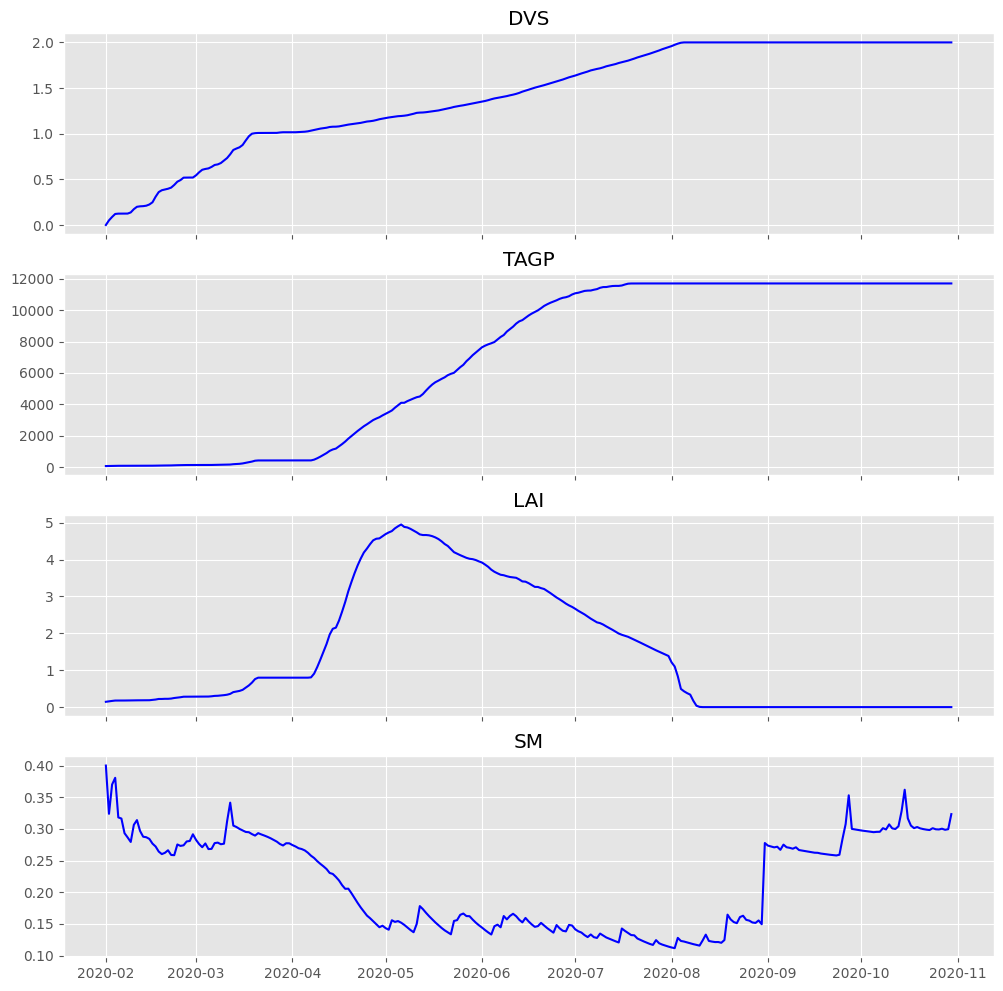

In [37]:
for a in range(len(weatherlist)):
    for b in range(len(weatherlist[a])):
        fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12,12), sharex=True)
        for var, ax in zip(["DVS", "TAGP", "LAI", "SM"], axes.flatten()):
            ax.plot(wofsim_results[a][b].index, wofsim_results[a][b][var], 'b-')
            ax.set_title(var)
        plt.show()
        #fig.autofmt_xdate()